In [1]:
import os
import os.path as op
import numpy as np
import glob
import csv
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats
import sklearn
import patsy
from scipy.optimize import minimize
from sklearn import linear_model
import multiprocessing
import random
%matplotlib inline

In [2]:
#Read in data
data_dir = os.path.abspath('../')
all_rts = pd.read_csv(data_dir + '/all_rts.csv', index_col =0)
exp_order = pd.read_csv(data_dir + '/exp_order.csv', index_col =0)
exp_order = exp_order.set_index(['exp','run'])

subjects = list(np.loadtxt(data_dir+ '/subjects.txt',str))

#some experiment variables
order_dict_ser = {'c_plus':6, 'b_plus':2, 'b_minus':3, 'c_minus':5} #coding for trial order vector
order_dict_sim = {'c_plus':4, 'b_plus':1, 'b_minus':2, 'c_minus':3}
order_dict_exp = {'ser': order_dict_ser, 'sim':order_dict_sim}

order_dict_reverse_exp = {}
for exp in ['sim','ser']:
    order_dict = order_dict_exp[exp]
    order_dict_reverse = {val:key for key,val in zip(order_dict.keys(),order_dict.values())}
    order_dict_reverse[10] = None
    if exp == 'ser':
        order_dict_reverse[1] = None
        order_dict_reverse[4] = None
    order_dict_reverse_exp[exp] = order_dict_reverse.copy()

In [3]:
### process the RTs a bit (remove trial types 1, 4, and 10 (see below) and mean center)
ser_rts = all_rts[all_rts['exp']=='ser']
ser_rts = ser_rts[ser_rts['order'] != 10] #ITI
ser_rts = ser_rts[ser_rts['order'] != 1] #A
ser_rts = ser_rts[ser_rts['order'] != 4] #A

sim_rts = all_rts[all_rts['exp']=='sim']
sim_rts = sim_rts[sim_rts['order'] != 10] #ITI

rt_dict_exp = {'ser': ser_rts, 'sim':sim_rts}

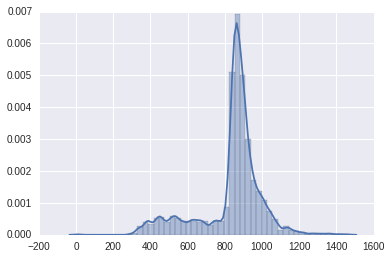

In [4]:
a = ser_rts.dropna()
a = a['rt'].values
a = [rt for rt in a if rt < 100000]
sns.distplot(a);

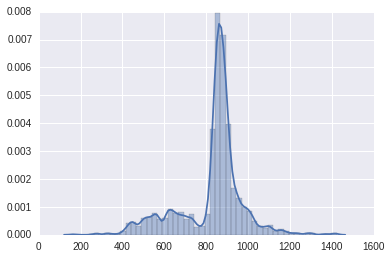

In [5]:
a = sim_rts.dropna()
a = a['rt'].values
a = [rt for rt in a if rt < 100000]
sns.distplot(a);

# Load RSA data

In [139]:
cond_name_map = {'AB+':'b_plus','AC-':'c_minus','B-':'b_minus','C+':'c_plus'}
# in_f = op.abspath('../rsa_time_resid.csv')
in_f = op.abspath('../rsa.csv')
rsa = pd.read_csv(in_f)

#rename things for convenience
rsa['trial1'] = [int(x.split('_')[1]) for x in rsa['cond1']]
rsa['trial2'] =[int(x.split('_')[1]) for x in rsa['cond2']]
rsa['cond1'] = [cond_name_map[x.split('_')[0]] for x in rsa['cond1']]
rsa['cond2'] =[cond_name_map[x.split('_')[0]] for x in rsa['cond2']]
# rsa = rsa.rename(columns = {'resid':'corr', 'region':'mask'})

#make symmetric for easier indexing
rsa2 = rsa.copy()
rsa2['cond1'] = rsa['cond2']
rsa2['cond2'] = rsa['cond1']
rsa2['trial1'] = rsa['trial2']
rsa2['trial2'] = rsa['trial1']
rsa = pd.concat([rsa,rsa2])

# #preprocess a bit
rsa.loc[rsa['corr'] == 1,'corr'] = 0 #set diaganol from 1 to 0 (isnt used)

# #make hierarchical
rsa = rsa.set_index(['mask','sub','run','cond1','cond2','trial1','trial2'])
rsa = rsa.loc['hipp']
rsa = rsa.sort_index()

In [142]:
# rsa['corr'] = [sigmoid(x,1,0) for x in rsa['corr']]
# sns.distplot(rsa['corr'])

In [8]:
def sigmoid(x,scale,b):
    return 1 / (1 + np.exp(-(x-b)*scale))

0.832018385134


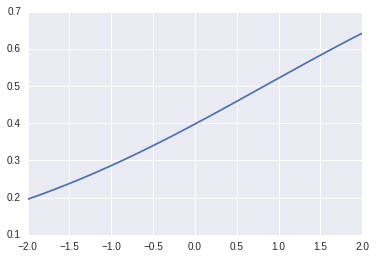

In [138]:
x = np.arange(-2,2,.01)
y = [sigmoid(x1,.5,.83) for x1 in x]
# y = [2*scipy.stats.logistic.cdf(x1)-1 for x1 in x] 
plt.plot(x,y)
print scipy.stats.logistic.cdf(1.6)

# RL  Models

### First define some general functions that will be reused across our algorithms

In [10]:
#the same data structures are utilized across algorithms
def build_data_structures(order_dict):
    V = {x:[0] for x in order_dict.keys()}
    delta = {x:[] for x in order_dict.keys()}
    index = {x:[] for x in order_dict.keys()}
    
    return V, delta, index

In [11]:
def do_rl(rew_trial,trial_type,V,alpha,n):
    rew = rew_trial[n]
    PE = rew - V[trial_type][-1] #compute PE
    new_V = V[trial_type][-1] + alpha * PE #calculate V for next trial

    return new_V, PE

In [12]:
def update_data_structures(V, delta, index, trial_type, count, PE, new_V):
    delta[trial_type].append(PE) 
    V[trial_type].append(new_V) 
    
    count += 1
    index[trial_type].append(count)
    
    return V, delta, index, count

### Now define each RL model

In [24]:
def standard_RL(trial_order,rew_trial,alpha,exp,rsa,run,sub):
    order_dict = order_dict_exp[exp]
    V, delta, index = build_data_structures(order_dict)
    count = 0
    for n,cond in enumerate(trial_order):
        trial_type = order_dict_reverse_exp[exp][cond]
                
        if trial_type is not None:

            #perform standard RL update
            new_V, PE = do_rl(rew_trial,trial_type,V,alpha,n)
            
            #log results
            V, delta, index, count = update_data_structures(V, delta, index, trial_type, count, PE, new_V)

    return V, delta, index

In [25]:
#This RL algorithm keeps one state representation for each event
def dumb_RL(trial_order,rew_trial,rl_params,exp,rsa,run,sub):
    
    alpha, omega = rl_params

    order_dict = order_dict_exp[exp]
    V, delta, index = build_data_structures(order_dict)

    trial_map = {'b_plus':['b_minus','c_minus'], 'b_minus' : ['b_plus'], 
                 'c_plus' :[ 'c_minus'],'c_minus':['c_plus','b_plus']} #mapping for leak
    count = 0
    for n,cond in enumerate(trial_order):
        trial_type = order_dict_reverse_exp[exp][cond]
                
        if trial_type is not None:

            #perform standard RL update
            new_V, PE = do_rl(rew_trial,trial_type,V,alpha,n)
            
            #log results
            V, delta, index, count = update_data_structures(V, delta, index, trial_type, count, PE, new_V)

            #do the dumb update to the other trial type
            for other_cond in trial_map[trial_type]:
                new_V = V[other_cond][-1] + alpha * PE * omega
                V[other_cond].pop() #remove old V
                V[other_cond].append(new_V) 

    return V, delta, index

In [72]:
def brain_RL(trial_order,rew_trial,rl_params,exp,sub_rsa,run,sub):
    
    alpha,omega,scale, shift = rl_params
    
    trial_map = {'b_plus':['b_minus','c_minus'], 'b_minus' : ['b_plus'], 
                 'c_plus' :[ 'c_minus'],'c_minus':['c_plus','b_plus']} #mapping for leak
    #set up storage structures
    order_dict = order_dict_exp[exp]
    local_rsa = pd.DataFrame({x:{y:0 for y in order_dict.keys()} for x in order_dict.keys()})
    V, delta, index = build_data_structures(order_dict)

    count = 0
    for n,cond in enumerate(trial_order):
        trial_type = order_dict_reverse_exp[exp][cond]
                
        if trial_type is not None:

            #perform standard RL update
            new_V, PE = do_rl(rew_trial,trial_type,V,alpha,n)
            
            #log results
            V, delta, index, count = update_data_structures(V, delta, index, trial_type, count, PE, new_V)

            #find the index of the most recent trial from each of the other conditions
            other_conds = [x for x in order_dict.keys() if x != trial_type]
                           
            #loop through other conditions and get most recent similarity
            for other_cond in other_conds:
                trial2 = np.sum(trial_order[0:n] == order_dict[other_cond]) -1     
                trial1 = len(index[trial_type]) - 1
                
                if trial2 >= 0: #must have occured for there to be similarity
                    corr = float(sub_rsa.loc[(run,trial_type,other_cond,trial1,trial2)]['corr'])
                    corr = sigmoid(corr,scale,shift)
                    local_rsa.loc[other_cond,trial_type] = corr
            
            #loop through other conditions and blend value update
            for other_cond in other_conds:
                if other_cond in trial_map[trial_type]: #only blend if share features
                    corr = local_rsa[trial_type][other_cond]
                    new_V = V[other_cond][-1] + alpha * PE * (omega + corr)
                    V[other_cond].pop() #remove old V
                    V[other_cond].append(new_V) 
    return V, delta, index

In [45]:
def leak_RL(trial_order,rew_trial,rl_params,exp,rsa,run,sub):
    
    alpha,omega = rl_params
    trial_map = {'b_plus':['b_minus','c_minus'], 'b_minus' : ['b_plus'], 
                 'c_plus' :[ 'c_minus'],'c_minus':['c_plus','b_plus']} #mapping for leak
    #set up storage structures
    order_dict = order_dict_exp[exp]
    V, delta, index = build_data_structures(order_dict)

    count = 0
    for n,cond in enumerate(trial_order):
        trial_type = order_dict_reverse_exp[exp][cond]
                
        if trial_type is not None:

            #perform standard RL update
            new_V, PE = do_rl(rew_trial,trial_type,V,alpha,n)
            
            #log results
            V, delta, index, count = update_data_structures(V, delta, index, trial_type, count, PE, new_V)

            #loop through other conditions and blend value update
            other_conds = [x for x in order_dict.keys() if x != trial_type]
            for other_cond in other_conds:
                if other_cond in trial_map[trial_type]: #only blend if share features
                    new_V = V[other_cond][-1] + alpha * PE * omega
                    V[other_cond].pop() #remove old V
                    V[other_cond].append(new_V) 
    return V, delta, index

In [46]:
#This RL algorithm keeps one state representation for each event
def single_item_state(trial_order,rew_trial,alpha,exp,rsa,run,sub):    
    V = {'A':[0], 'B' : [0], 'C' : [0]}
    order_dict = order_dict_exp[exp]
    V_std, delta, index = build_data_structures(order_dict)

    trial_map = {'b_plus':['A','B'], 'b_minus' : ['B'], 
                 'c_plus' : ['C'],'c_minus':['A','C']} #mapping for leak
    
    count = 0
    for n,cond in enumerate(trial_order):
        trial_type = order_dict_reverse_exp[exp][cond]
                
        if trial_type is not None:
            rew = rew_trial[n]
            
            V_trial = 0
            for state in trial_map[trial_type]:
                V_trial += V[state][-1]
            
            #do correct RL update
            PE = rew - V_trial
            delta[trial_type].append(PE) #compute PE
            V_std[trial_type].append(V_trial)
            
            for state in trial_map[trial_type]:
                new_V = V[state][-1] + alpha * PE
                V[state].append(new_V)
 
            index[trial_type].append(count)
            count += 1
    
    return V_std, delta, index

In [47]:
def null_RL():
    return None

# now fit models

In [19]:
##function for building dataframe of relevant data for each subject
def build_df_all_bothexp(num_runs, subjects):
    alpha = .1
    exp_list = ['ser','sim']
    predictors = {'exp':[],'subject':[],'V':[],'PE':[],'run':[], 'cond':[], 'trial_index':[],'rt':[]}

    for i in range(1,num_runs+1):
        for exp in exp_list:
            order_dict = order_dict_exp[exp]
            
            ##perform RL for the experimental condition
            event_order = exp_order.loc[exp]
    
            rew = exp_order.loc[(exp,i),'rew'].values
            tt = exp_order.loc[(exp,i),'trial_order'].values
            V, delta, index = standard_RL(tt,rew,alpha,exp,None,None)
            for key in V.keys():
                V[key] = V[key][:-1] #last entry is for subsequent trial that doesnt exist

            for sub in subjects:

                #get rt data for this subject and run
                rts = rt_dict_exp[exp]
                rt_data = rts[(rts['sub']==sub) & (rts['run']==i) ]

                ##update predictors dict
                for key in V.keys():
                    predictors['V'].extend(V[key])
                    predictors['PE'].extend(delta[key])
                    predictors['cond'].extend([key]*len(V[key]))
                    predictors['exp'].extend([exp]*len(V[key]))
                    predictors['subject'].extend([sub]*len(V[key]))
                    predictors['run'].extend(['run' + str(i)]*len(V[key]))
                    predictors['trial_index'].extend(index[key])
                    predictors['rt'].extend(rt_data[rt_data['order']==key]['rt'].values)
    predictors = pd.DataFrame(predictors)
    predictors = predictors.sort(['subject','run','trial_index']) #get predictors in proper order
    predictors = predictors.set_index(['exp', 'subject','run'])

    predictors['rt'] = np.log(predictors['rt'])
#     horrible nasty code to set response indexing. Hopfully i will find something more elegant one day
    for exp in ['sim','ser']:
        for sub in subjects:
            for run in map(str,range(1,4)):
                sub_df = predictors.loc[(exp,sub,'run' + run)]

                response = ~np.isnan(sub_df.loc[:,'rt'])
                nresponses = len(sub_df.loc[response,'trial_index'].values)
                idx = range(nresponses)
                idx = scipy.stats.zscore(idx)

                sub_df.loc[response,'resp_index'] = idx
                predictors.loc[(exp,sub,'run' + run), 'resp_index'] = sub_df.loc[(exp,sub,'run' + run),'resp_index'].values

    #add condition to the hierarchy
    predictors.set_index('cond', append=True, inplace=True)
    predictors.reset_index(level='cond')
    predictors = predictors.sort_index()
    predictors = z_score_dataframe(predictors,exp_list)

    return predictors

In [20]:
#Z score dataframe
def z_score_dataframe(predictors,exps):
    for sub in subjects:
        for exp in exps:
            for i in range(1,num_runs+1):
                run = 'run' + str(i)

                #mean center each run
                vals = predictors.loc[(exp,sub,run),'rt'].values
                vals = (vals - np.nanmean(vals))/np.nanstd(vals)
                predictors.loc[(exp,sub,run),'rt'] = vals

                #Z-score trial index for each row
                predictors.loc[(exp,sub,run),'trial_index'] = scipy.stats.zscore(predictors.loc[(exp,sub,run),'trial_index'])
    return predictors

In [116]:
def set_params(RL_func, params):
    if RL_func.func_name == 'null_RL':        
        alpha = 0
        beta = params[1:]
        beta[-1] = 0 #set beta to 0
        rl_params = alpha
        RL_func = standard_RL
    elif RL_func.func_name in ['leak_RL','dumb_RL']:
        alpha = scipy.stats.logistic.cdf(params[0]) #learning rate
        omega = scipy.stats.logistic.cdf(params[1]) #blend rate, positive
        beta = params[2:]
        rl_params = (alpha,omega)
    elif RL_func.func_name == 'brain_RL':
        alpha = scipy.stats.logistic.cdf(params[0]) #learning rate
        omega = scipy.stats.logistic.cdf(params[1]) #blend rate, positive
        scale = scipy.stats.logistic.cdf(params[2])*20 #blend rate, positive
        shift = scipy.stats.logistic.cdf(params[3])*4 - 2 #shift
        beta = params[4:]
        rl_params = (alpha,omega,scale,shift)
    else:
        alpha = scipy.stats.logistic.cdf(params[0]) #learning rate
        beta = params[1:]
        rl_params = alpha
        
    return RL_func, rl_params, beta

In [65]:
sub_to_nruns = {sub:len(set(rsa.loc[sub].index.get_level_values(0))) for sub in subjects}

In [119]:
##returns loss for linear regression
def regress_all(params,predictors,rsa,exp,RL_func,subjects):
        
    ##Set up parameter specific stuff according to the RL function
    RL_func, rl_params, beta = set_params(RL_func,params)

    ##perform RL for the experimental condition
    for sub in subjects:
        sub_rsa = rsa.loc[sub]
        num_runs = sub_to_nruns[sub]
    
        for i in range(1,num_runs+1):
            run_order = exp_order.loc[('sim',i)]
            rew = run_order['rew'].values
            tt = run_order['trial_order'].values
            V, delta, index = RL_func(tt,rew,rl_params,exp,sub_rsa,i,sub)

            for key in V.keys():
                predictors.loc[(sub,'run' + str(i),key),'V'] = np.array(V[key][:-1])

    #build RL matrixes
    yd,Xd = patsy.dmatrices("rt ~ resp_index + V",predictors,NA_action='drop')
    X = np.asarray(Xd)

    #drop intercept
    X = X[:,1:] 
    X = X - np.mean(X,0)
    y=np.array(map(float,np.asarray(yd)))
    y = y - np.mean(y)

    #compute prediction and loss
    y_hat = np.dot(X,beta)
    loss = np.linalg.norm(y - y_hat)
    sigma = np.std(y - y_hat)

    ll = len(y) * np.log(1/(sigma *np.sqrt(2*np.pi))) - (1.0/(2*sigma**2))*(loss**2)
    ll =  ll*-1
    
    return ll

In [114]:
# #set up experiment specific variables
# num_runs = 3
# predictors = build_df_all_bothexp(num_runs,subjects)

# a = pd.DataFrame(predictors.to_records())
# a.to_csv('/home/iballard/Dropbox/fd/rt_fitting/predictors.csv',index = False)


In [112]:
sub = 'fd_105'
exp = 'sim'
rl_alg = leak_RL
params = [.1,0,-1,-1]

# sub_predictors = sub_predictors.sort_index()
regress_all(params,sub_predictors,rsa,exp,rl_alg, subjects)

3052.9478067487885

In [143]:
def run_subjects(in_tuple):
    
    exp, rl_alg, method, params = in_tuple

    bad_subs = ['fd_107','fd_108','fd_109','fd_122']
    good_subs = [x for x in subjects if x not in bad_subs]
    
    sub_predictors = predictors.loc[exp].copy()

    #minimize
    minimizer_kwargs = {"method": method, 'args':(sub_predictors,rsa,exp,
                                                    rl_alg,good_subs)}
    try:
        res = basinhopping(regress_all, params, minimizer_kwargs=minimizer_kwargs,niter=1)
    except:
        return (exp,rl_alg,'Failed')
    
    return (exp,rl_alg,method,res)

In [144]:
#define variables
exp = 'sim'
from scipy.optimize import basinhopping
rl_params = {standard_RL:[0,0,0],single_item_state:[0,0,0],
             leak_RL:[0,0,-1,-1],null_RL:[0,0,0],
            brain_RL:[0,0,0,0,0,0]}

# rl_params = {brain_RL:[scipy.stats.logistic.ppf(.095),scipy.stats.logistic.ppf(.445),0,0,.9, -7.6]}

in_tuples = []
method = ['CG']

for alg, params in rl_params.iteritems():
    for meth in method:
        in_tuples.append((exp, alg ,meth,params))
        
# run_subjects(in_tuples[0])
# in_tuples

In [ ]:
del res
pool = multiprocessing.Pool(8)
res = pool.map(run_subjects,in_tuples)
pool.terminate()
pool.join()


In [146]:
res

[('sim',
  <function __main__.brain_RL>,
  'CG',
                          fun: 2463.266785901971
 lowest_optimization_result:      fun: 2463.266785901971
     jac: array([ 0.01727295, -0.04434204, -0.01574707, -0.02542114,  0.20050049,
        0.02279663])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 3556
     nit: 186
    njev: 443
  status: 2
 success: False
       x: array([-1.1127798 ,  3.53351839,  0.63936703,  0.03800245, -0.01244594,
        0.00948397])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 2
                       nfev: 3632
                        nit: 1
                       njev: 451
                          x: array([-1.1127798 ,  3.53351839,  0.63936703,  0.03800245, -0.01244594,
        0.00948397])),
 ('sim',
  <function __main__.standard_RL>,
  'CG',
                          fun: 2416.5148395693723
 lowest_optimization_result:      fun: 

In [103]:
#parse result of minimization into a DF
def res_to_df(res):
    out_df = {}
    
    out_df = {'alpha':[],'beta':[],'trial':[],
              'sub':[],'ll':[],
              'omega':[],'shift':[], 'scale':[],
              'exp':[], 'alg':[]}
        
    for n,out in enumerate(res):
        if out[-1] == 'Failed':
            print out[0],out[1],out[2]
        else:
            sub, exp, rl_alg, meth, o1 = out
            o = o1.lowest_optimization_result
            RL_func = rl_alg.func_name

            out_df['sub'].append(sub)
            out_df['exp'].append(exp)
            out_df['alg'].append(RL_func)
            if o.success or o.message == 'Desired error not necessarily achieved due to precision loss.' or 'Maximum number of function evaluations has been exceeded.':      
                if RL_func == 'leak_RL':
                    out_df['omega'].append(scipy.stats.logistic.cdf(o.x[1]))
                    out_df['beta'].append(o.x[3])
                    out_df['trial'].append(o.x[2])
                    out_df['shift'].append(np.NaN)
                    out_df['scale'].append(np.NaN)
                elif RL_func == 'brain_RL':
                    out_df['omega'].append(scipy.stats.logistic.cdf(o.x[1]))
                    out_df['shift'].append(scipy.stats.logistic.cdf(o.x[3])*6-3)
                    out_df['scale'].append(scipy.stats.logistic.cdf(o.x[2])*40)
                    out_df['beta'].append(o.x[5])
                    out_df['trial'].append(o.x[4])
                else:
                    out_df['beta'].append(o.x[2])
                    out_df['trial'].append(o.x[1])
                    out_df['omega'].append(np.NaN)
                    out_df['shift'].append(np.NaN)
                    out_df['scale'].append(np.NaN)

                out_df['alpha'].append(scipy.stats.logistic.cdf(o.x[0]))
                out_df['ll'].append(-1*o.fun)

            else:
                out_df['alpha'].append(np.NaN)
                out_df['beta'].append(np.NaN)
                out_df['trial'].append(np.NaN)
                out_df['ll'].append(np.NaN)
                out_df['omega'].append(np.NaN)
                out_df['shift'].append(np.NaN)
                out_df['scale'].append(np.NaN)

    return pd.DataFrame(out_df)

In [104]:
df = res_to_df(res)
df.to_csv('/home/iballard/Dropbox/fd/rt_fitting/df_brain.csv',index = False)
# df = pd.read_csv('/home/iballard/Dropbox/fd/rt_fitting/df_brain.csv')

bad_subs = ['fd_107','fd_108','fd_109','fd_122']

for s in bad_subs:
    df = df[df['sub'] != s]
df = df.set_index(['alg'])


In [105]:
scipy.stats.wilcoxon(df.loc['brain_RL']['beta'])
# a = df.loc['brain_RL','ll'].values - df.loc['leak_RL','ll'].values
# plt.hist(a)


WilcoxonResult(statistic=16.0, pvalue=2.0602777134809463e-05)

# Compare models using Bayesian RFX

In [106]:
#perform log likelihood ratio test
def llrt(alt_data,null_data,freedom):
    ratio = 2*(alt_data['ll'].values - null_data['ll'].values)
    test_stat = map(lambda x: stats.chi2.sf(x,freedom), ratio)
    sig = np.array(test_stat) < .05

    alt_data['chi'] = test_stat
    alt_data['sig'] = sig
    return alt_data

In [107]:
#perform log likelihood ratio test for all subjects
def llrt_group(alt_data,null_data,freedom):
    ratio = 2*np.sum((alt_data['ll'].values) - null_data['ll'].values)
    print ratio
    test_stat = stats.chi2.sf(ratio,freedom*null_data.shape[0])
    sig = np.array(test_stat) < .05

    return test_stat, sig

In [120]:
a = df.loc['brain_RL','ll'].values - df.loc['leak_RL','ll'].values
a[a<0]=0
stats.chi2.sf(np.sum(a)*2,10)

0.030488762173496577

In [111]:
llrt(df.loc['brain_RL'],df.loc['leak_RL'],1)
# df.loc['brain_RL']

/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,alpha,beta,exp,ll,omega,scale,shift,sub,trial,chi,sig
alg,,,,,,,,,,,
brain_RL,0.786303,-0.037621,sim,-38.329764,1.000000e+00,3.993039e+01,2.912478,fd_104,-0.294298,0.300668,False
brain_RL,0.999999,-0.892686,sim,-77.911775,5.885218e-01,3.996188e+01,2.804143,fd_105,-0.286527,1.000000,False
brain_RL,0.095122,-7.654793,sim,-68.235156,4.458424e-01,3.999888e+01,3.000000,fd_110,0.905184,1.000000,False
brain_RL,0.975291,-0.709515,sim,-81.098587,3.967277e-01,2.141051e+01,0.089295,fd_112,-0.055670,0.139200,False
brain_RL,0.333686,-1.764920,sim,-81.674965,6.101561e-01,3.045365e+01,2.800348,fd_113,0.109244,1.000000,False
brain_RL,0.344261,-1.928163,sim,-68.703090,1.701324e-06,3.999299e+01,0.053341,fd_114,0.422592,0.444197,False
brain_RL,0.450241,-1.185076,sim,-81.439709,2.552310e-01,1.982745e-01,-2.999786,fd_115,0.009105,0.149582,False
brain_RL,0.089221,-7.870943,sim,-68.547481,3.826239e-01,3.999637e+01,0.260938,fd_117,0.921642,0.726251,False
brain_RL,0.150663,0.251462,sim,-81.061278,9.999988e-01,3.999933e+01,-0.318836,fd_118,-0.061296,1.000000,False


In [52]:
sub = 'fd_110'
exp = 'sim'
rl_alg = leak_RL
params = [scipy.stats.logistic.ppf(.095),scipy.stats.logistic.ppf(.445),.9, -7.6]

sub_predictors = predictors.loc[exp,sub]
sub_rsa = rsa.loc[sub] #deepcopy for speed

regress_all(params,sub_predictors,sub_rsa,num_runs,exp,rl_alg,'ll')
scipy.stats.logistic.ppf(0)

-inf

In [216]:
llrt(df.loc['brain_RL'],df.loc['leak_RL'],1)

print df[df['sub'] == 'fd_110']

                      alpha      beta  exp         ll     omega  scale  \
alg                                                                      
brain_RL           0.294753  0.058768  sim -80.827967  0.999996     40   
dumb_RL            0.095123  0.905180  sim -68.235156       NaN    NaN   
single_item_state  0.105106 -3.244657  sim -75.781938       NaN    NaN   
standard_RL        0.354389 -1.997735  sim -69.754233       NaN    NaN   
null_RL            0.616178  0.000000  sim -81.733342       NaN    NaN   
leak_RL            0.095123 -7.654711  sim -68.235156  0.445844    NaN   

                      shift     sub     trial  
alg                                            
brain_RL           0.008803  fd_110  0.116276  
dumb_RL                 NaN  fd_110 -0.217475  
single_item_state       NaN  fd_110  0.572717  
standard_RL             NaN  fd_110  0.341196  
null_RL                 NaN  fd_110  0.138915  
leak_RL                 NaN  fd_110  0.905180  


/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [52]:
def calc_bic(ll,n_params,n_obs):
    return -2*ll + n_params*np.log(n_obs)

In [53]:
def calc_aicc(ll,n_params,n_obs):
    return -2*ll + 2*n_params + (2*n_params * (n_params+1))/(n_obs*1.0 - n_params -1)

In [54]:
from pymatbridge import Matlab
mlab = Matlab()
%load_ext pymatbridge


/home/iballard/anaconda/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-ecba91c0-6d7e-42bf-a4dd-e415b64aeabb
Send 'exit' command to kill the server
.........MATLAB started and connected!


In [65]:
#write to text file
path = op.abspath('../rt_fitting/evidence/')
for m in set(df.index):

    if m in ['leak_RL','dumb_RL']:
        n_params = 4
    elif m == 'brain_RL':
        n_params = 6
    elif m == 'null_RL':
        n_params = 1
    else:
        n_params = 3
        
    aic = []
    bic = []
    for sub,ll in zip(df.loc[m,'sub'].values,
                      df.loc[m,'ll'].values):
        
        n_obs =  np.loadtxt(op.abspath('../rt_fitting/n_obs/') + '/' + exp + '_' + sub + '_nobs')

        aic.append(calc_aicc(ll,n_params,n_obs))
        bic.append(calc_bic(ll,n_params,n_obs))

    np.savetxt(op.join(path, m + '_aic'),aic)
    np.savetxt(op.join(path, m + '_bic'),bic)


In [66]:
%%matlab -o pxp_b
path = '/home/iballard/Dropbox/fd/rt_fitting/evidence/';
ic = '_bic';
brain = textread([path,'brain_RL',ic]);
null = textread([path,'null_RL',ic]);
standard = textread([path,'standard_RL',ic]);
single = textread([path,'single_item_state',ic]);
dumb = textread([path,'dumb_RL',ic]);
leak = textread([path,'leak_RL',ic]);
lc = [null, dumb];
lc = lc*-1;
[alpha,exp_r,xp,pxp_b,bor] = spm_BMS(lc);

In [67]:
%%matlab -o pxp_a
path = '/home/iballard/Dropbox/fd/rt_fitting/evidence/';
ic = '_aic';
brain = textread([path,'brain_RL',ic]);
null = textread([path,'null_RL',ic]);
standard = textread([path,'standard_RL',ic]);
single = textread([path,'single_item_state',ic]);
dumb = textread([path,'dumb_RL',ic]);
leak = textread([path,'leak_RL',ic]);
lc = [null, dumb];
lc = lc*-1;
[alpha,exp_r,xp,pxp_a,bor] = spm_BMS(lc);

(0, 1)

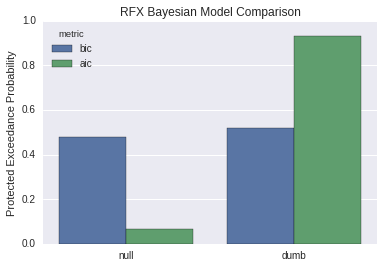

In [68]:
model = ['null','dumb']

xp_df = pd.DataFrame({'model':model*2,
                      'Protected Exceedance Probability':list(pxp_b[0]) + list(pxp_a[0]),
                     'metric':['bic']*len(model) + ['aic']*len(model) })
ax = sns.barplot(x = 'model', y = 'Protected Exceedance Probability',
            hue = 'metric',data = xp_df,)
plt.title('RFX Bayesian Model Comparison')
plt.ylabel('Protected Exceedance Probability')
plt.xlabel('')
ax.set_ylim([0,1])
# plt.savefig('../figures/model_fit_full.png',dpi=600)